# Identifying Breast Cancer Clusters with Self-Organizing Maps
The dataset comes with sklearn and consists of physical properties of labeled malignant and benign tumors. The purpose of this notebook is to find meaning from the data by using Self-Organizing Maps to isolate the tumors into separate clusters.

In [99]:
%pip install minisom
from IPython.display import Image, display
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import time

You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [100]:
# load data
dataset = load_breast_cancer()

In [101]:
target = dataset.target
target_names = dataset.target_names
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data.index.name = "Sample ID"

In [102]:
# visualize data
pd.set_option('display.max_columns', None)
print('gene expressions')
display(data.head())
print(data.shape)
print('\ntarget key')
display(pd.DataFrame(target_names).head())
print('\nclassification')
display(pd.DataFrame(target).head())

gene expressions


mean radius  mean texture  mean perimeter  mean area  \
Sample ID                                                         
0                17.99         10.38          122.80     1001.0   
1                20.57         17.77          132.90     1326.0   
2                19.69         21.25          130.00     1203.0   
3                11.42         20.38           77.58      386.1   
4                20.29         14.34          135.10     1297.0   

           mean smoothness  mean compactness  mean concavity  \
Sample ID                                                      
0                  0.11840           0.27760          0.3001   
1                  0.08474           0.07864          0.0869   
2                  0.10960           0.15990          0.1974   
3                  0.14250           0.28390          0.2414   
4                  0.10030           0.13280          0.1980   

           mean concave points  mean symmetry  mean fractal dimension  \
Sample ID                                                               
0                      0.14710         0.2419                 0.07871   
1                      0.07017         0.1812                 0.05667   
2                      0.12790         0.2069                 0.05999   
3                      0.10520         0.2597                 0.09744   
4                      0.10430         0.1809                 0.05883   

           radius error  texture error  perimeter error  area error  \
Sample ID                                                             
0                1.0950         0.9053            8.589      153.40   
1                0.5435         0.7339            3.398       74.08   
2                0.7456         0.7869            4.585       94.03   
3                0.4956         1.1560            3.445       27.23   
4                0.7572         0.7813            5.438       94.44   

           smoothness error  compactness error  concavity error  \
Sample ID                                                         
0                  0.006399            0.04904          0.05373   
1                  0.005225            0.01308          0.01860   
2                  0.006150            0.04006          0.03832   
3                  0.009110            0.07458          0.05661   
4                  0.011490            0.02461          0.05688   

           concave points error  symmetry error  fractal dimension error  \
Sample ID                                                                  
0                       0.01587         0.03003                 0.006193   
1                       0.01340         0.01389                 0.003532   
2                       0.02058         0.02250                 0.004571   
3                       0.01867         0.05963                 0.009208   
4                       0.01885         0.01756                 0.005115   

           worst radius  worst texture  worst perimeter  worst area  \
Sample ID                                                             
0                 25.38          17.33           184.60      2019.0   
1                 24.99          23.41           158.80      1956.0   
2                 23.57          25.53           152.50      1709.0   
3                 14.91          26.50            98.87       567.7   
4                 22.54          16.67           152.20      1575.0   

           worst smoothness  worst compactness  worst concavity  \
Sample ID                                                         
0                    0.1622             0.6656           0.7119   
1                    0.1238             0.1866           0.2416   
2                    0.1444             0.4245           0.4504   
3                    0.2098             0.8663           0.6869   
4                    0.1374             0.2050           0.4000   

           worst concave points  worst symmetry  worst fractal dimension  
Sample ID                           

(569, 30)

target key


0
0  malignant
1     benign


classification


0
0  0
1  0
2  0
3  0
4  0

# Exploratory Data Analysis
We can view distributions and correlation heatmaps with EDA. The advantage of Self-Organizing Maps is that they can cluster high dimensional data and present it to us in a way that's easy to visualize.

## Distplots are Incredible...
For seeing the distributions between a few variables.

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


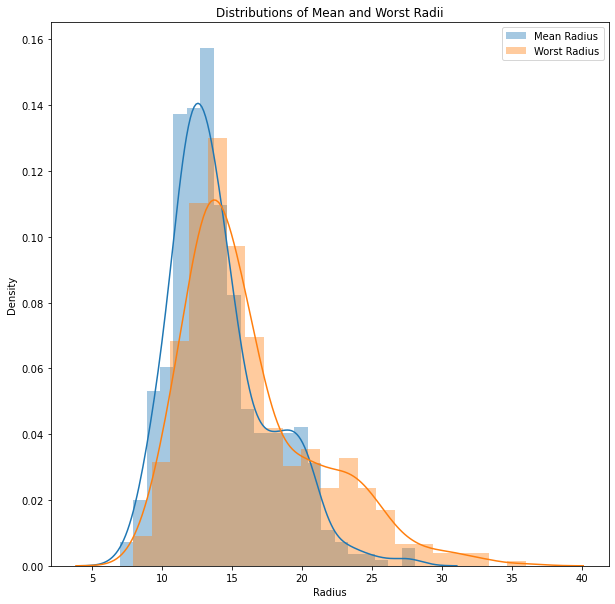

In [103]:
plt.figure(figsize=(10, 10))
sns.distplot(data.loc[:, "mean radius"], label="Mean Radius")
sns.distplot(data.loc[:, "worst radius"], label="Worst Radius")
plt.title("Distributions of Mean and Worst Radius")
plt.legend()
plt.xlabel("Radius")
plt.ylabel("Density")
plt.show()

## Correlation Heatmaps can Find Important Features
By taking the correlations between every variable we can find out where to look for significance.

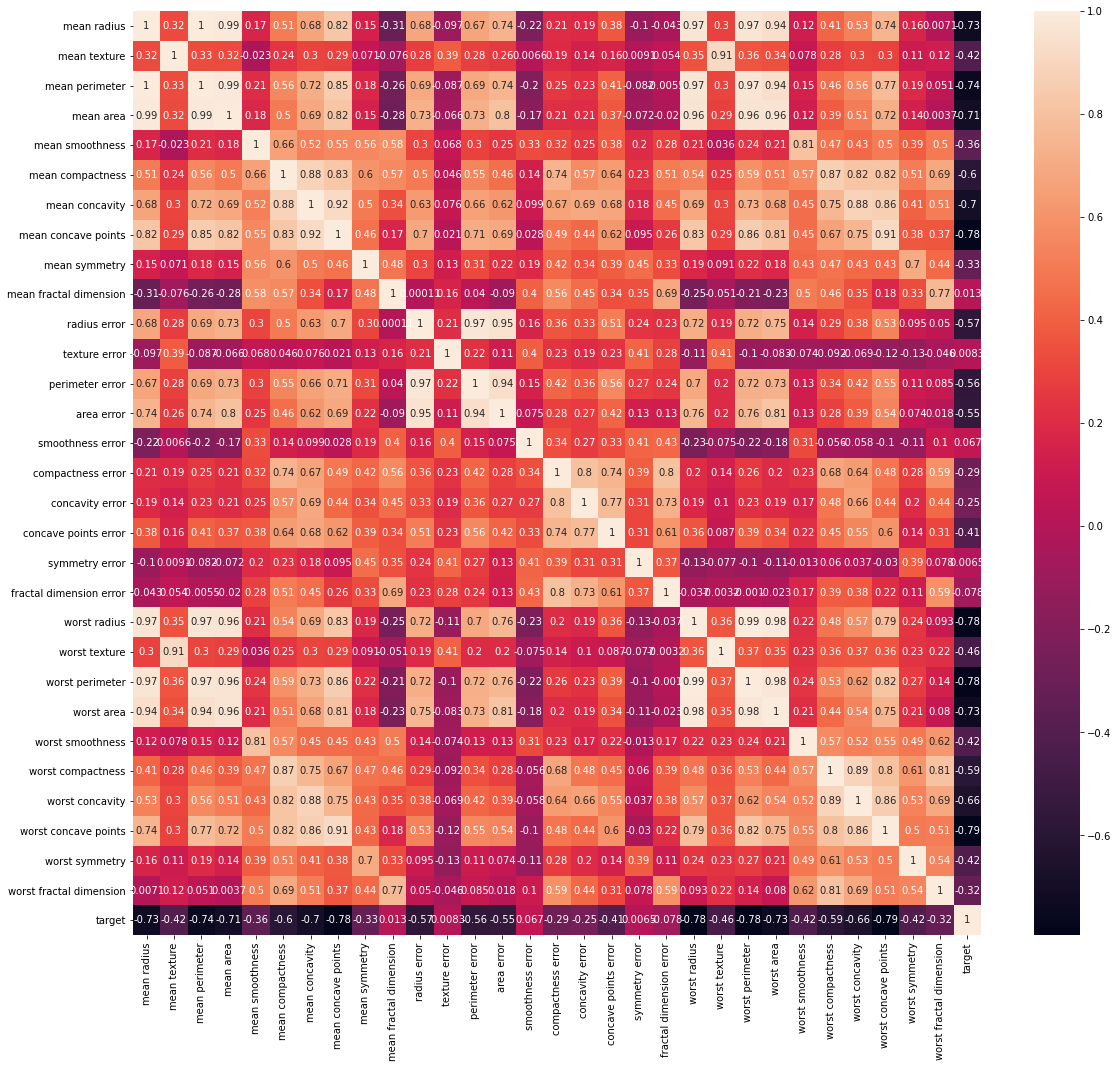

In [104]:
data_and_target = pd.concat([data, pd.DataFrame(target, columns=["target"])], axis=1)
Var_Corr = data_and_target.corr()
plt.figure(figsize=(19, 17))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

## Self-Organizing Maps can Map the Data in the Input Space to the Output Space
<img src="Architecture-of-self-organizing-feature.jpeg">

In [105]:
# set hyperparameters
x = 30
y = 30
input_len = data.shape[1]
sigma = 1
learning_rate = 0.5
iterations = 100

In [106]:
# initialization
data = np.array(data) # convert from dataframe to np array
som = MiniSom(x=x,
             y=y,
             input_len=input_len,
             sigma=sigma,
             learning_rate=learning_rate)
som.random_weights_init(data)

In [107]:
# training
start_time = time.time()
som.train_random(data, iterations) # training with 100 iterations
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")

0.033895015716552734  seconds


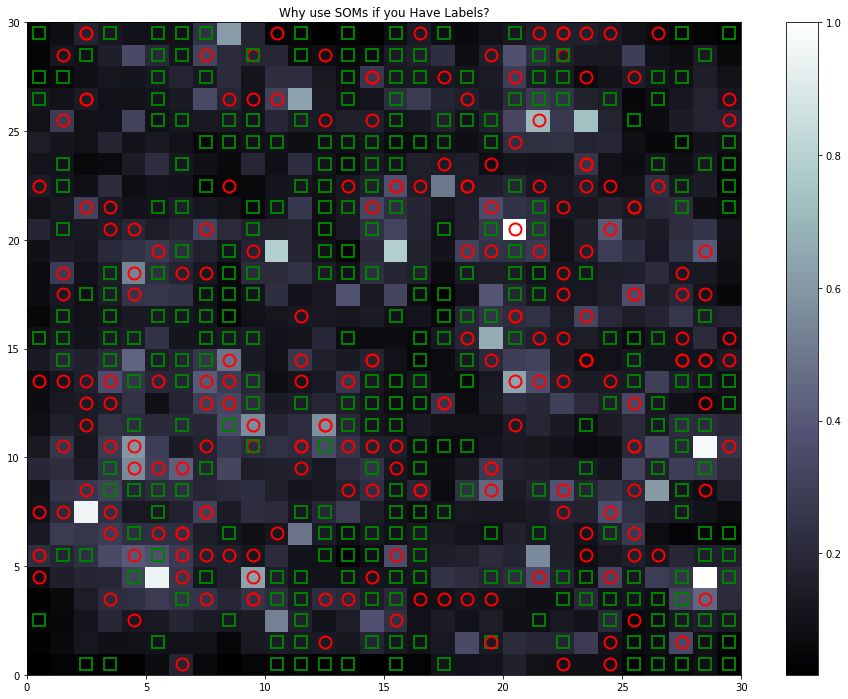

In [108]:
from pylab import plot, axis, show, pcolor, colorbar, bone

plt.figure(figsize=(16, 12))
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()

# use different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['r', 'g', 'b']
for cnt, xx in enumerate(data):
    w = som.winner(xx) # getting the winner
    # place a maker on the winning position for the sample xx
    plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
         markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)

plt.title("Why use SOMs if you Have Labels?")
axis((0, som._weights.shape[0], 0, som._weights.shape[1]))
show() # show the figure

# How to optimize a SOM?

## What are MiniSom's Hyperparameters?
* x: number of columns
* y: number of rows
* sigma: spread of the neighborhood function
    * needs to be adequate to the dimensions of the map. sigma < x/2.0 and sigma < y/2.0
* learning_rate
* iterations

# What Error Should we Minimize?
The **Quantization Error** is computed by determining the average distance of the sample vectors to the cluster centroids by which they may represented.

$$
\Large Q = \frac{1}{m}\sum_{q=1}^{m}{\left \| \overrightarrow{x}^q - \overrightarrow{w_i}^q \right \|}^2
$$

Notice how the Euclidean Distance is embedded into the Quantization Error.

$$
\large S_{j, i} = \left \| w_j - w_i \right \|
$$

"The Quanitization Error QE declines as the map becomes larger. Thus, the Quanitization Error can not be used to compare maps of different sizes."
- Pölzlbauer, Georg. (2004). Survey and comparison of quality measures for self-organizing maps
https://www.researchgate.net/publication/228847397_Survey_and_comparison_of_quality_measures_for_self-organizing_maps

The grid size should be constant according to Vesanto (2005), so apply a heuristic:
- J. Vesanto. (2005). Clustering of the self-organizing map
https://www.semanticscholar.org/paper/Clustering-of-the-self-organizing-map-Vesanto-Alhoniemi/931521da1f1b8f4ed47d638e1747a87f38506db4
- x = np.sqrt(5*np.sqrt(rows_of_data))
- y = x

In [109]:
# imports
# %pip install hyperopt
from hyperopt import fmin, tpe, hp
import time

In [110]:
def train_som(x, y, input_len, sigma, learning_rate):
    # initialization
    som = MiniSom(x=x,
                 y=y,
                 input_len=input_len,
                 sigma=sigma,
                 learning_rate=learning_rate)
    som.random_weights_init(data)
    # training
    start_time = time.time()
    som.train_random(data, iterations) # training with 100 iterations
    elapsed_time = time.time() - start_time
    print(elapsed_time, " seconds")
    return som

def plot_som(som):
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o', 's', 'D']
    colors = ['r', 'g', 'b']
    for cnt, xx in enumerate(data):
        w = som.winner(xx) # getting the winner
        # place a maker on the winning position for the sample xx
        plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
    axis((0, som._weights.shape[0], 0, som._weights.shape[1]))
    show() # show the figure

In [112]:
# set hyperparameters
rows_data = data.shape[0]
x = int(np.sqrt(5 * np.sqrt(rows_data)))
y = x
input_len = data.shape[1]
sigma = 0.003
learning_rate = 5
iterations = 100
print("x is {}".format(x))

x is 10


In [113]:
som = train_som(x, y, input_len, sigma, learning_rate)

0.010318756103515625  seconds


In [114]:
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate))

x: 10
y: 10
input_len: 30
sigma: 0.003
learning_rate: 5


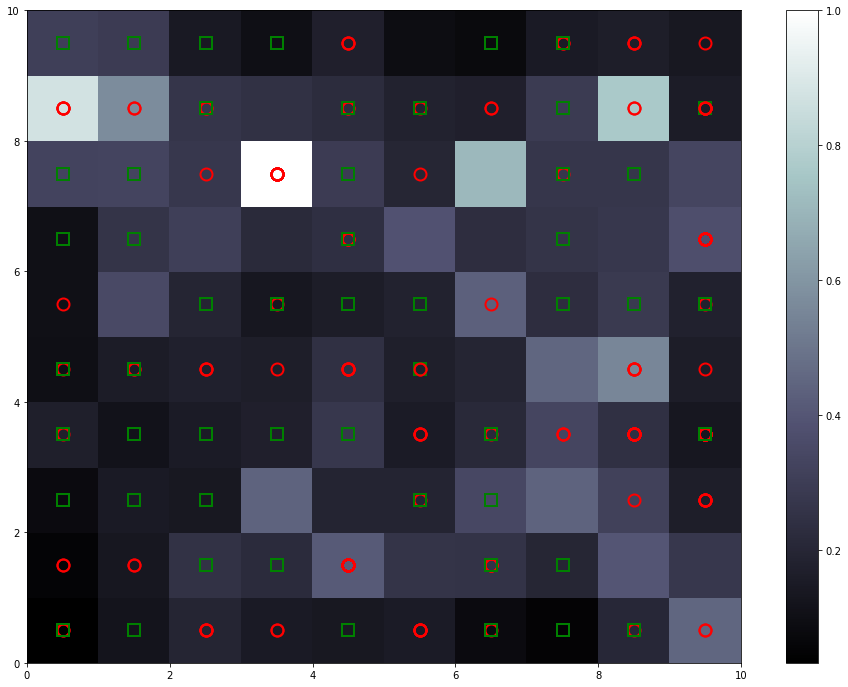

In [115]:
plot_som(som)

# Bayeian Optimization
<img src="Bayesian Optimization.jpg">

## Tuning Sigma by Reducing Quantization Error with hyperpot.fmin
1. Give observed values of the loss function, f(x), udpate the posterior expectation of f using the Gaussian Process model.
2. Find xnew maximises the Expected Imporvement (EI): xnew = argmaxEI(x).
3. Compute the value of f for the point xnew.

For further reading, go to Thomas Huijskens's Github page: http://thuijskens.github.io/2016/12/29/bayesian-optimisation/

Minimizes an objective function. In our case, We are minimizing the **minisom.MiniSom.quantization_error(self, data)** method. We transform the method into a
Lambda function in order to pass it through to the parameter **fn**.

Hyperopt: A Python Library for Optimizing theHyperparameters of Machine Learning Algorithms
https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf

In [116]:
start_time = time.time()
best = fmin(
    fn = lambda sig: MiniSom(x=x,
                            y=x,
                            input_len=input_len,
                            sigma=sig,
                            learning_rate=learning_rate
                            ).quantization_error(data),
    space=hp.uniform("sig", 0.001, x / 2.01), # sigma can not be greater than x/2
    algo=tpe.suggest,
    max_evals=200
)
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")
print(best)

100%|██████████| 200/200 [00:02<00:00, 75.61trial/s, best loss: 1111.192140237423] 
2.680853843688965  seconds
{'sig': 4.3050286255730175}


In [117]:
# hyperparameters
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate))

x: 10
y: 10
input_len: 30
sigma: 4.3050286255730175
learning_rate: 5


In [118]:
som = train_som(x, y, input_len, sigma, learning_rate)

0.009650945663452148  seconds


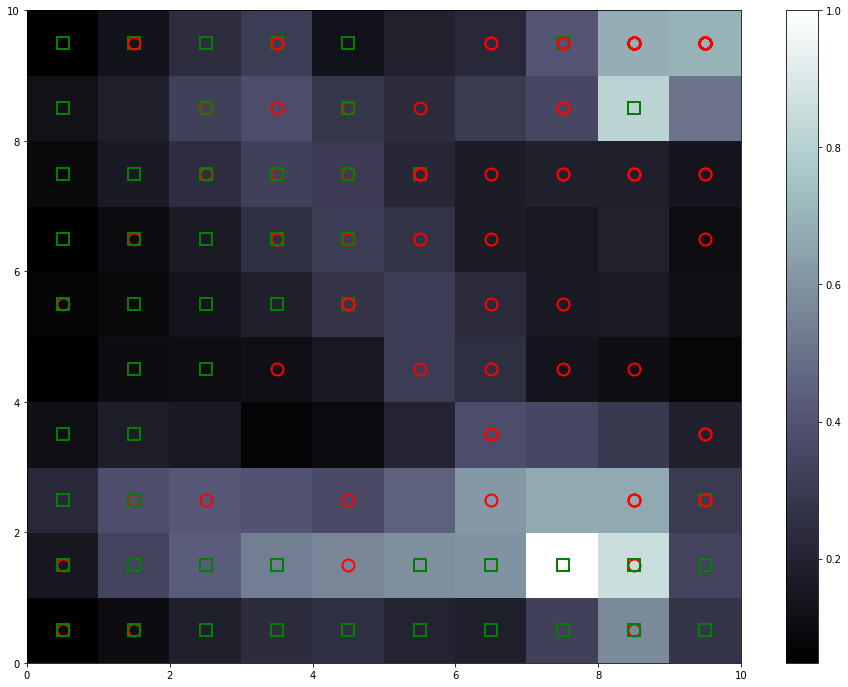

In [119]:
plot_som(som)

### For better visualizations, we can use plotly
* https://plotly.com
* https://www.kaggle.com/asparago/unsupervised-learning-with-som

## Optimizing Sigma and the Learning Rate
The learning rate was still high (5). Typical learning rates for convolutional neural networks are around 0.005 to 0.05.

In [120]:
from hyperopt import Trials, STATUS_OK

space = {
    'sig': hp.uniform('sig', 0.001, 5),
    'learning_rate': hp.uniform('learning_rate', 0.001, 5)
}

def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x,
                 y=x,
                 input_len=input_len,
                 sigma=sig,
                 learning_rate=learning_rate
                 ).quantization_error(data)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

print('best: {}'.format(best))

for i, trials in enumerate(trials.trials[:2]):
    print(i, trials)

1111.2398212842281                                     
1111.2406384797139                                     
1111.3361832562946                                                               
1111.3204981959502                                                               
1111.266671125622                                                                
1111.2692102507483                                                               
1111.2231831948432                                                               
1111.2577749908864                                                               
1111.265855040934                                                                
1111.3095372544212                                                               
1111.3584066814194                                                               
1111.224005682005                                                                 
1111.2614213239376                                                 

In [121]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,
                                                                        y,
                                                                        input_len,
                                                                        sigma,
                                                                        learning_rate))

x: 10
y: 10
input_len: 30
sigma: 0.8717768136682749
learning_rate: 4.043991980106375


In [122]:
som = train_som(x, y, input_len, sigma, learning_rate)

0.009823083877563477  seconds


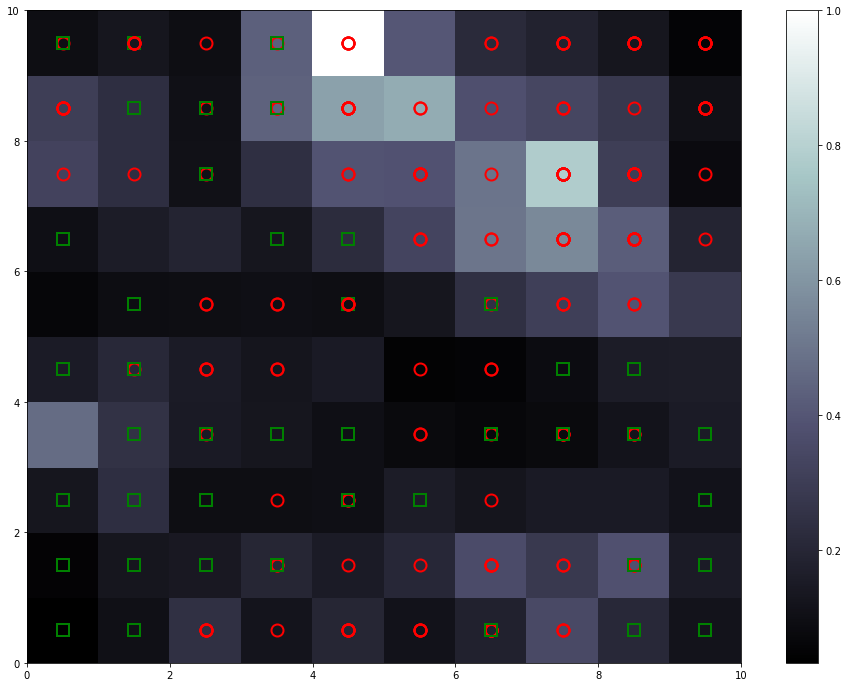

In [123]:
plot_som(som)